In [42]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [43]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [47]:
# DB Config
uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time

timestamp = date_time.map(dt.timestamp)

day = 24*60*60
week = 7*day
year = (365.2425)*day

hh_datas['week sin'] = np.sin(timestamp * (2 * np.pi / week)).values
hh_datas['week cos'] = np.cos(timestamp * (2 * np.pi / week)).values
hh_datas['year sin'] = np.sin(timestamp * (2 * np.pi / year)).values
hh_datas['year cos'] = np.cos(timestamp * (2 * np.pi / year)).values

hh_datas

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.099,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 00:15:00,0.103,-0.851662,-0.524092,0.880700,-0.473674
2018-05-01 00:30:00,0.084,-0.856525,-0.516106,0.880615,-0.473832
2018-05-01 00:45:00,0.079,-0.861313,-0.508075,0.880530,-0.473990
2018-05-01 01:00:00,0.105,-0.866025,-0.500000,0.880445,-0.474148
...,...,...,...,...,...
2019-04-30 22:45:00,0.030,-0.958287,0.285808,0.883173,-0.469047
2019-04-30 23:00:00,0.033,-0.955573,0.294755,0.883089,-0.469205
2019-04-30 23:15:00,0.038,-0.952775,0.303677,0.883005,-0.469363


In [55]:
# Split Data Code
split_datas = hh_datas[0::4]

# Merging Data Code
count = 0
merge_datas = pd.DataFrame(columns=['kw (15min)'])
merge_datas['kw (15min)'] = [
    round(hh_datas[
        idx * 4:
        (idx + 1) * 4
    ].mean().values[0], 3)
    for idx in range(0, round(len(hh_datas) / 4))
]
merge_datas.index = [
    hh_datas.index[idx * 4]
    for idx in range(0, round(len(hh_datas) / 4))
]

In [56]:
# training datas 80%
# validation datas 10%
# validation datas 10%
val_days = []
test_days = []

val_data_percentage = 10
test_data_percentage = 10

# Mon.1 ~ Mon.12
for month in range(1,13):
    val_day_list = []
    test_day_list = []
    day_list = list(set(
        split_datas[split_datas.index.month == month].index.day
    ))
    month_datas = split_datas[split_datas.index.month == month].copy()
    start_day = day_list[0]
    end_day = day_list[len(day_list) - 1] + 1
    
    # 10 percentage split
    val_length = round(len(day_list)) / val_data_percentage
    test_length = round(len(day_list)) / test_data_percentage
    
    while True:
        if (len(val_day_list) >= val_length) and \
            (len (test_day_list) >= test_length):
            break
        while True:
            val_day = ran.randrange(start_day, end_day)
            test_day = ran.randrange(start_day, end_day)

            if (val_day != test_day) and \
                (val_day not in val_day_list + test_day_list) and \
                (test_day not in test_day_list + val_day_list):
                val_days.extend(
                    month_datas[
                        month_datas.index.day == val_day
                    ].index
                )
                test_days.extend(
                    month_datas[
                        month_datas.index.day == test_day
                    ].index
                )
                val_day_list.append(val_day)
                test_day_list.append(test_day)
                break;

train_days = split_datas.drop((val_days + test_days)).index

In [57]:
# Set Split Datas
train_split_df = split_datas.loc[train_days].copy()
val_split_df = split_datas.loc[val_days].copy()
test_split_df = split_datas.loc[test_days].copy()

# Set Merge Datas
train_merge_df = merge_datas.loc[train_days].copy()
val_merge_df = merge_datas.loc[val_days].copy()
test_merge_df = merge_datas.loc[test_days].copy()

In [58]:
train_split_df

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.099,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 01:00:00,0.105,-0.866025,-0.500000,0.880445,-0.474148
2018-05-01 02:00:00,0.094,-0.884115,-0.467269,0.880105,-0.474779
2018-05-01 03:00:00,0.094,-0.900969,-0.433884,0.879765,-0.475409
2018-05-01 04:00:00,0.086,-0.916562,-0.399892,0.879424,-0.476040
...,...,...,...,...,...
2019-04-30 19:00:00,0.116,-0.988831,0.149042,0.884431,-0.466671
2019-04-30 20:00:00,0.045,-0.982566,0.185912,0.884096,-0.467305
2019-04-30 21:00:00,0.050,-0.974928,0.222521,0.883761,-0.467939


In [59]:
val_split_df

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2019-01-25 00:00:00,0.142,0.532032,0.846724,0.397175,0.917743
2019-01-25 01:00:00,0.138,0.563320,0.826239,0.397833,0.917458
2019-01-25 02:00:00,0.066,0.593820,0.804598,0.398491,0.917172
2019-01-25 03:00:00,0.056,0.623490,0.781831,0.399148,0.916887
2019-01-25 04:00:00,0.063,0.652287,0.757972,0.399805,0.916600
...,...,...,...,...,...
2018-12-26 19:00:00,0.160,-0.500000,0.866025,-0.093889,0.995583
2018-12-26 20:00:00,0.286,-0.467269,0.884115,-0.093175,0.995650
2018-12-26 21:00:00,0.344,-0.433884,0.900969,-0.092462,0.995716


In [60]:
test_split_df

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2019-01-17 00:00:00,0.118,-0.330279,0.943883,0.267517,0.963553
2019-01-17 01:00:00,0.122,-0.294755,0.955573,0.268207,0.963361
2019-01-17 02:00:00,0.089,-0.258819,0.965926,0.268898,0.963169
2019-01-17 03:00:00,0.075,-0.222521,0.974928,0.269588,0.962976
2019-01-17 04:00:00,0.082,-0.185912,0.982566,0.270278,0.962782
...,...,...,...,...,...
2018-12-31 19:00:00,0.108,-0.733052,-0.680173,-0.008014,0.999968
2018-12-31 20:00:00,0.236,-0.757972,-0.652287,-0.007297,0.999973
2018-12-31 21:00:00,0.123,-0.781831,-0.623490,-0.006580,0.999978


In [61]:
train_mean = train_split_df.mean()
train_std = train_split_df.std()
print("split data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_split = dict({
    "all": (split_datas - train_mean) / train_std,
    "train": (train_split_df - train_mean) / train_std,
    "val": (val_split_df - train_mean) / train_std,
    "test": (test_split_df - train_mean) / train_std
})

train_mean = train_merge_df.mean()
train_std = train_merge_df.std()
print("merge data // mean: {}, std: {}".format(train_mean.values, train_std.values))

norm_merge = dict({
    "all": (merge_datas - train_mean) / train_std,
    "train": (train_merge_df - train_mean) / train_std,
    "val": (val_merge_df - train_mean) / train_std,
    "test": (test_merge_df - train_mean) / train_std
})


split data // mean: [ 0.09714038 -0.01669217 -0.00212338 -0.00320535 -0.0060285 ], std: [0.09995475 0.6966747  0.7172939  0.7078721  0.70641335]
merge data // mean: [0.09704152], std: [0.0836454]


In [82]:
windows = dict()
norm = norm_split
for WINDOW_WIDTH in range(3, 21):
    windows['{} hours'.format(WINDOW_WIDTH)] = WindowGenerator(
        input_width=WINDOW_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=norm['train'],
        val_df=norm['val'],
        test_df=norm['test']
    )

In [83]:
val_performance = dict()
performance = dict()
models = dict()

for WINDOW_WIDTH in range(3, 21):
    IPython.display.clear_output()
    key = "{} hours".format(WINDOW_WIDTH)
    print("##### {} training start #####".format(key))
    
    cur_window = windows[key]
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    compile_and_fit(lstm_model, cur_window)
    val_performance[key] = lstm_model.evaluate(
                cur_window.val
            )
    performance[key] = lstm_model.evaluate(
                cur_window.test
            )
    models[key] = lstm_model

##### 20 hours training start #####
Epoch 1/40
209/209 [==============================] - 3s 7ms/step - loss: 0.9459 - mean_absolute_error: 0.5861 - val_loss: 0.8378 - val_mean_absolute_error: 0.5626
Epoch 2/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9270 - mean_absolute_error: 0.5730 - val_loss: 0.8395 - val_mean_absolute_error: 0.5467
Epoch 3/40
32/32 [==============================] - 0s 2ms/step - loss: 1.1963 - mean_absolute_error: 0.6365


In [84]:
all_val_performance = dict()
all_performance = dict()
lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

for WINDOW_WIDTH in range(3, 21):
    IPython.display.clear_output()
    print("##### {} hours training start #####".format(WINDOW_WIDTH))
    
    cur_window = windows['{} hours'.format(WINDOW_WIDTH)]
    compile_and_fit(lstm_model, cur_window)

for WINDOW_WIDTH in range(3, 21):
    key = "{} hours".format(WINDOW_WIDTH)
    all_val_performance[key] = lstm_model.evaluate(
                windows[key].val
            )
    all_performance[key] = lstm_model.evaluate(
                windows[key].test
            )

models['all'] = lstm_model

##### 20 hours training start #####
Epoch 1/40
209/209 [==============================] - 3s 9ms/step - loss: 0.8112 - mean_absolute_error: 0.5282 - val_loss: 0.9212 - val_mean_absolute_error: 0.5968
Epoch 2/40
209/209 [==============================] - 1s 6ms/step - loss: 0.8042 - mean_absolute_error: 0.5269 - val_loss: 0.9100 - val_mean_absolute_error: 0.5894
Epoch 3/40
209/209 [==============================] - 1s 6ms/step - loss: 0.7983 - mean_absolute_error: 0.5242 - val_loss: 0.9146 - val_mean_absolute_error: 0.5939
Epoch 4/40
32/32 [==============================] - 0s 2ms/step - loss: 1.2060 - mean_absolute_error: 0.6587


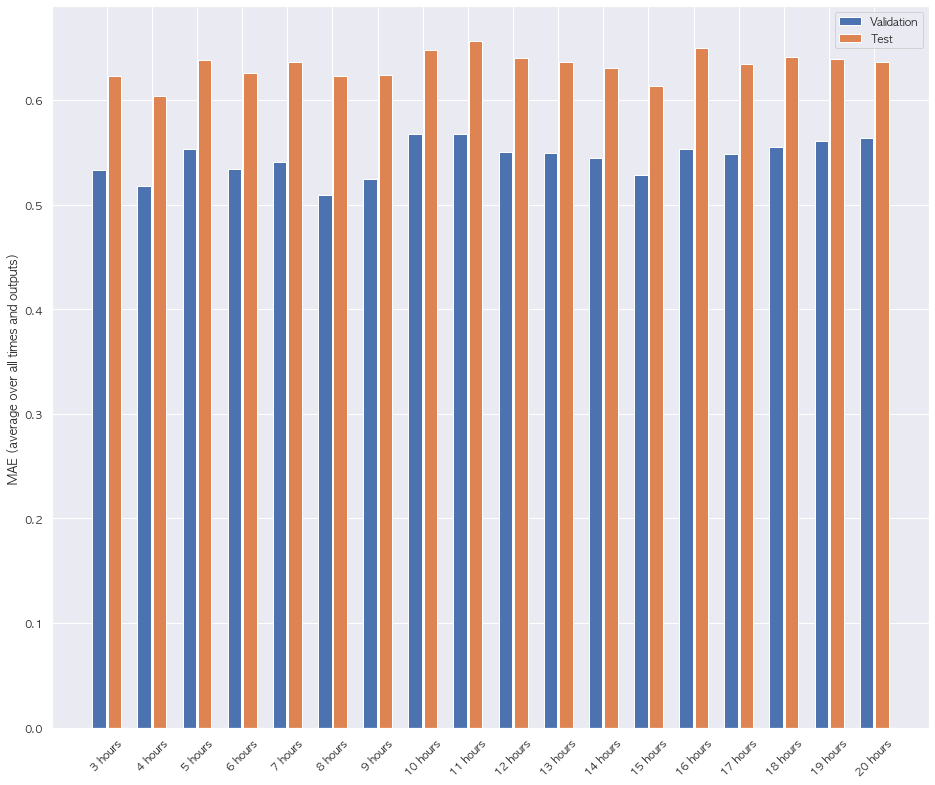

In [85]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

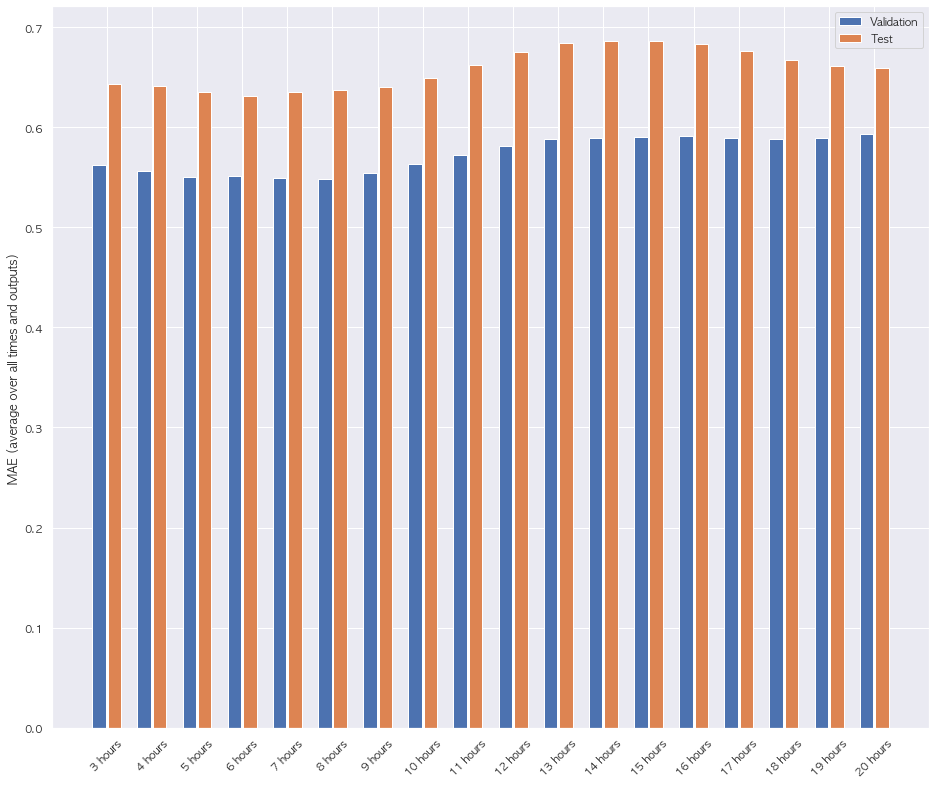

In [86]:
x = np.arange(len(all_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in all_val_performance.values()]
test_mae = [v[metric_index] for v in all_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=all_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


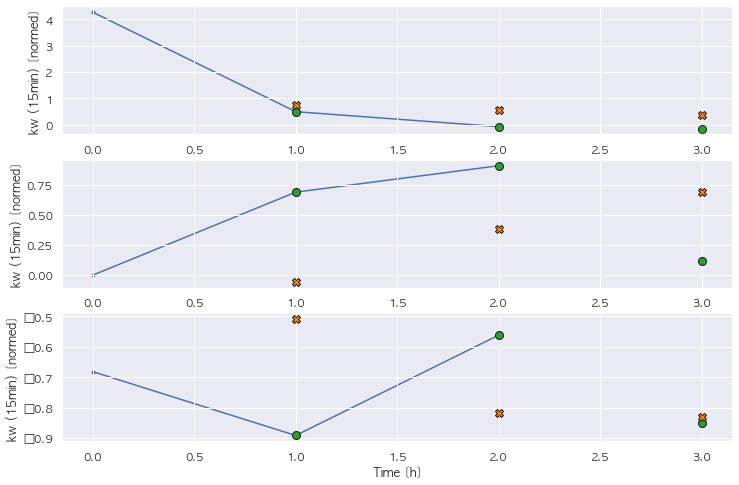

In [87]:
key = '3 hours'

plot_test = windows[key]
model = models[key]

test_window = WindowGenerator(
        input_width=3,
        label_width=3,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=norm_split['train'],
        val_df=norm_split['val'],
        test_df=norm_split['test']
    )

test_window.plot(model, max_subplots=3)

In [108]:
predict_size = 48

predict_window = WindowGenerator(
        input_width=predict_size,
        label_width=predict_size,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=norm['train'],
        val_df=norm['val'],
        test_df=norm['test']
    )

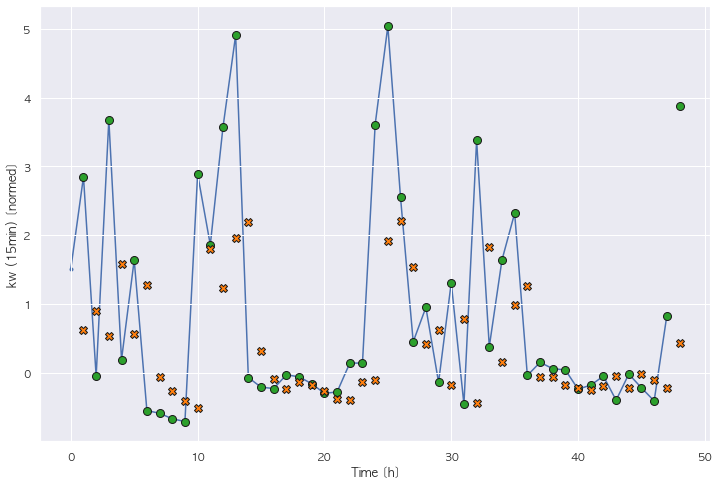

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


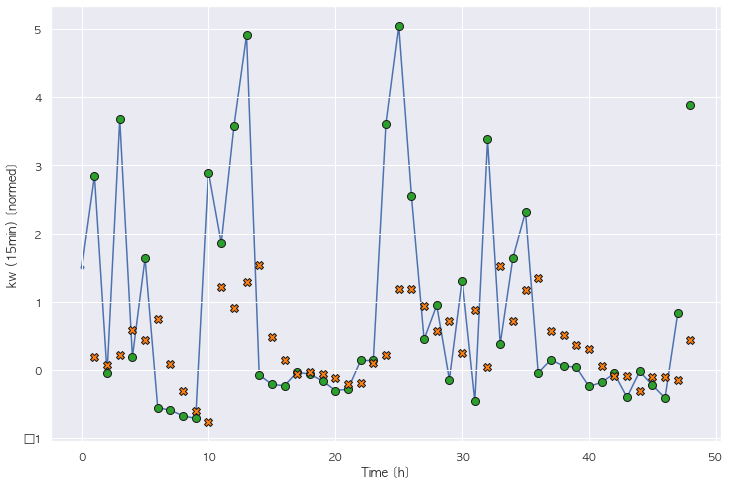

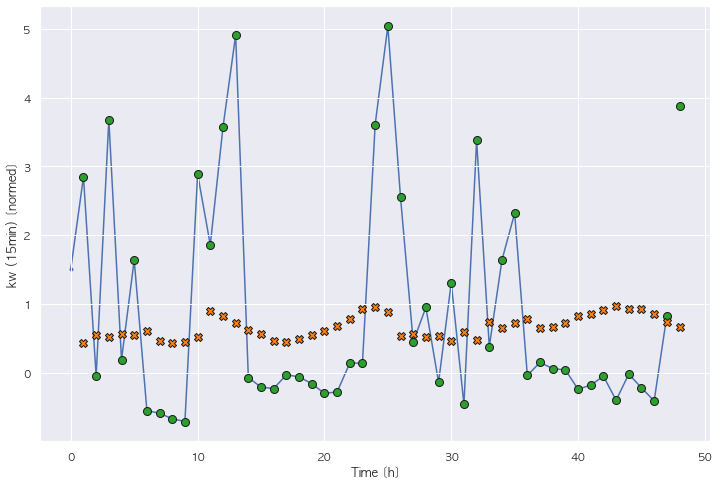

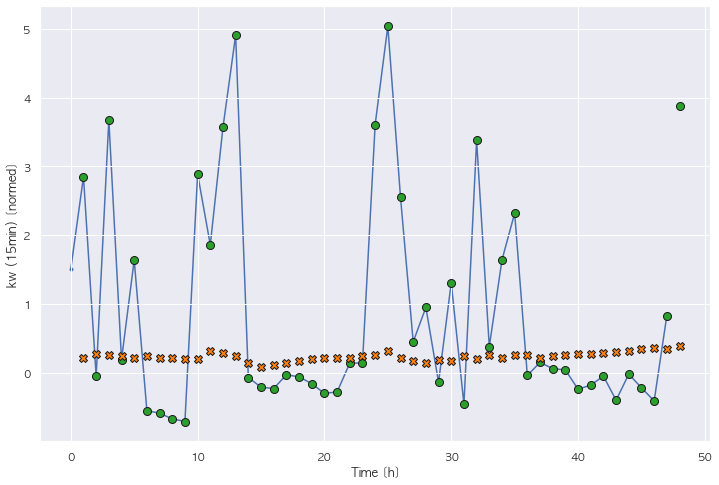

In [109]:
for WINDOW_WIDTH in range(3, 21, 5):
    key = "{} hours".format(WINDOW_WIDTH)
    predict_window.plot(models[key], max_subplots=1)

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

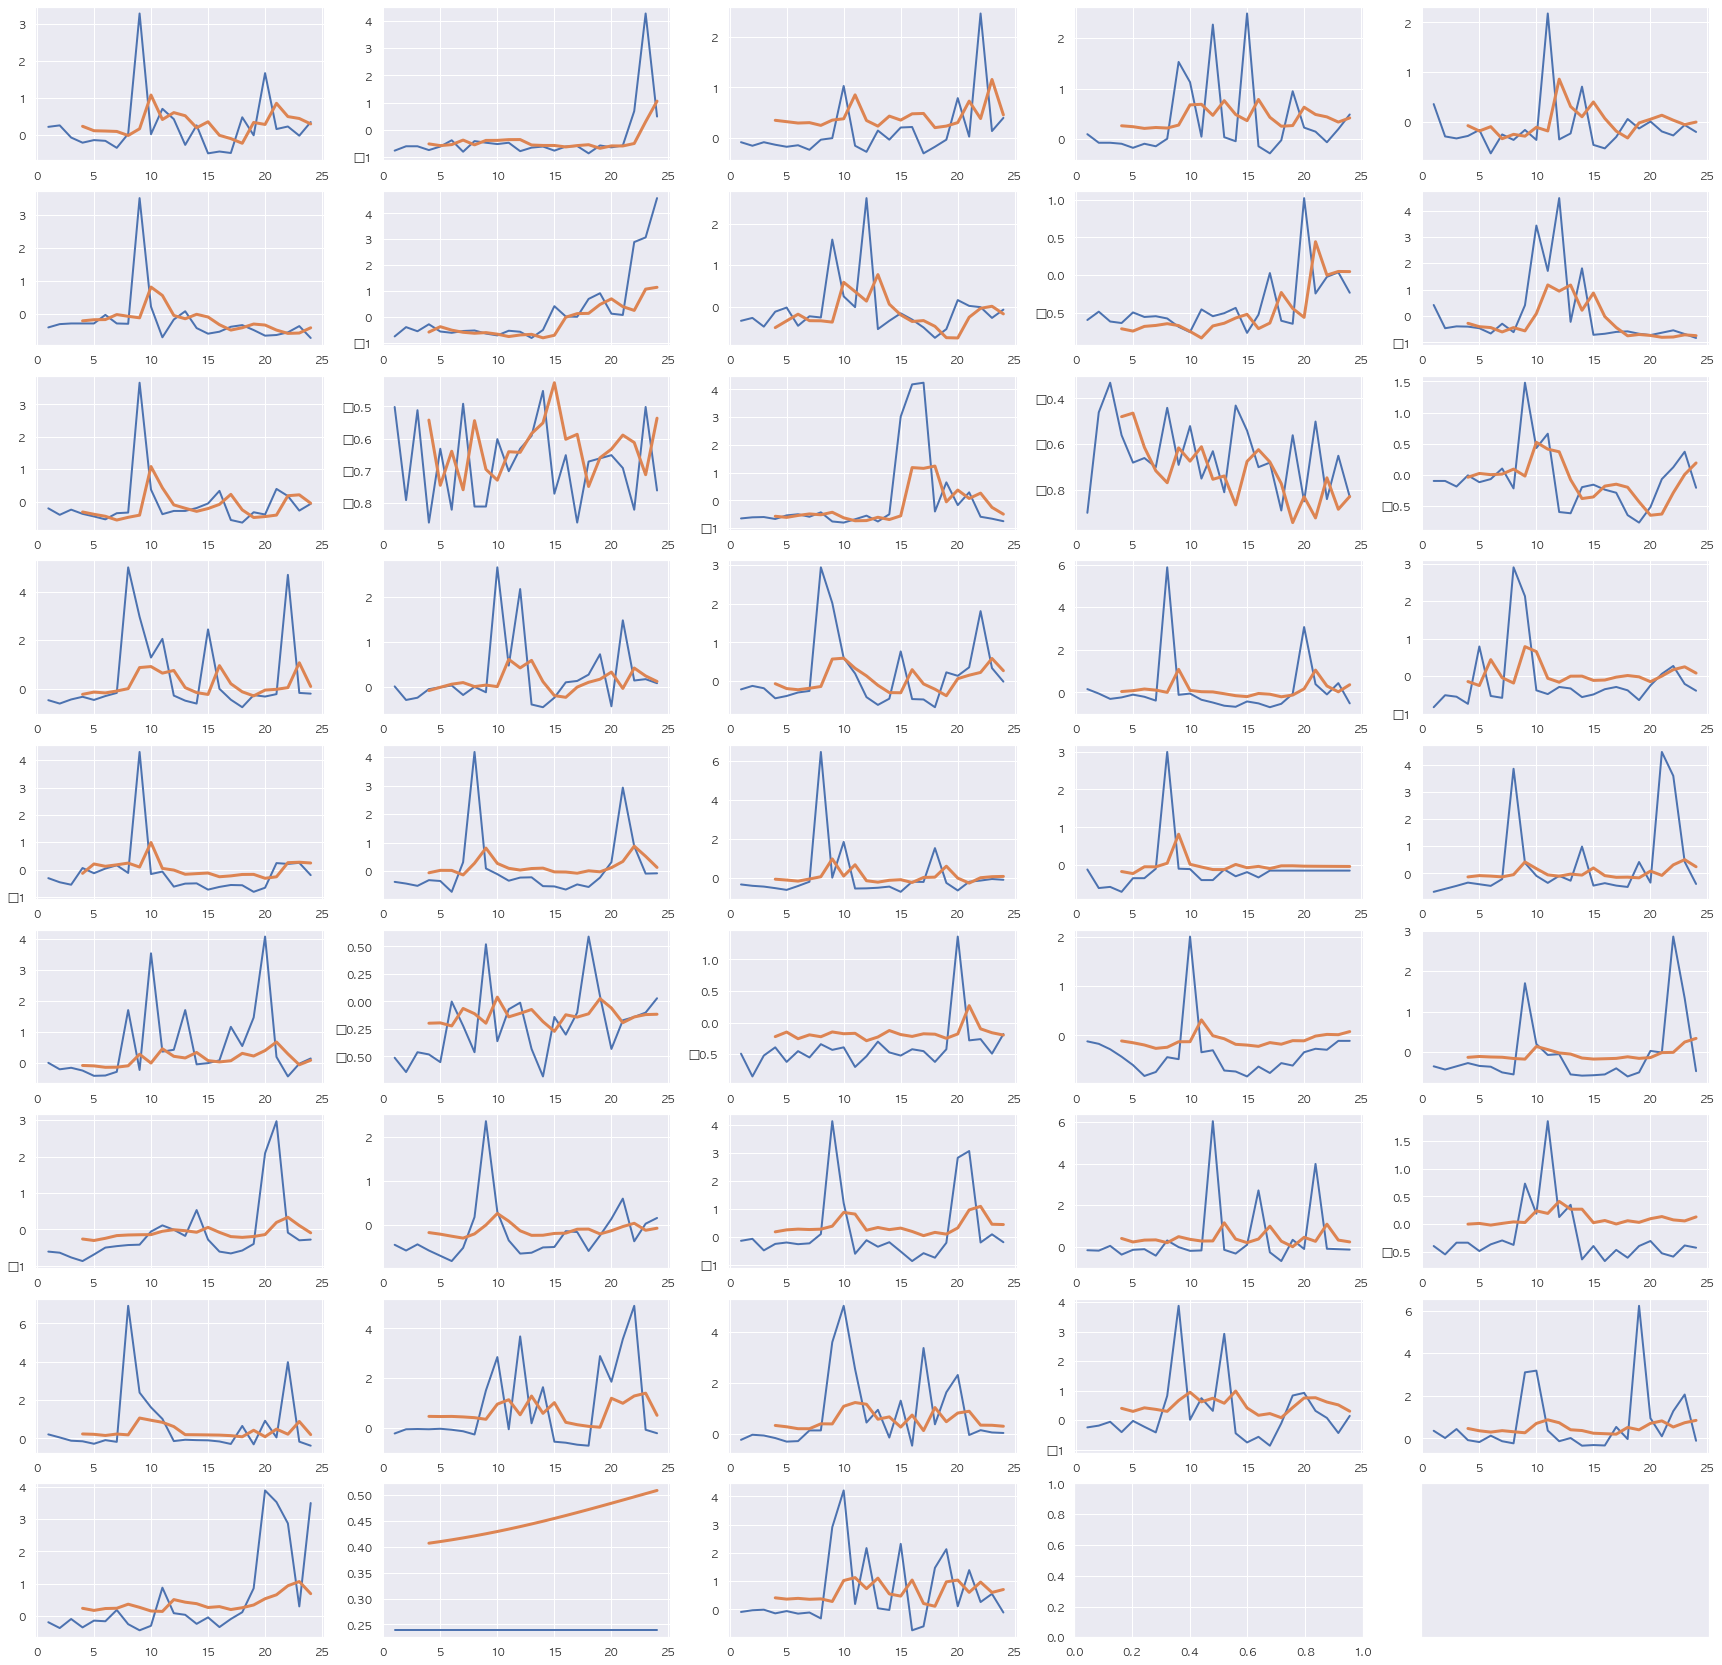

In [162]:
feature_length = 5
predict_data_length = 3
WINDOW_WIDTH = 3
fig, axes = plt.subplots(math.ceil(round(len(norm_split['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(norm_split['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)

    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = norm_split['test'][split:(split + 24)]['kw (15min)'].values.flatten()
    predicts = []
    inputs = []

    for idx in range(0, (24 - predict_data_length)):
        inputs = norm_split['test'][split:(split + 24)].values[idx:predict_data_length + idx].flatten()
        inputs = inputs.reshape(-1, predict_data_length,5)
        result = models[key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      